In [2]:
import argparse
import copy
import os
os.chdir('/root/bevfusion/')

import mmcv
import numpy as np
import torch
from mmcv import Config
from mmcv.parallel import MMDistributedDataParallel
from mmcv.runner import load_checkpoint
from torchpack import distributed as dist
from torchpack.utils.config import configs
# from torchpack.utils.tqdm import tqdm # this gives an import error
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# These take time to load
from mmdet3d.core import LiDARInstance3DBoxes
from mmdet3d.core.utils import visualize_camera, visualize_lidar, visualize_map
from mmdet3d.datasets import build_dataloader, build_dataset
from mmdet3d.models import build_model


def recursive_eval(obj, globals=None):
    if globals is None:
        globals = copy.deepcopy(obj)

    if isinstance(obj, dict):
        for key in obj:
            obj[key] = recursive_eval(obj[key], globals)
    elif isinstance(obj, list):
        for k, val in enumerate(obj):
            obj[k] = recursive_eval(val, globals)
    elif isinstance(obj, str) and obj.startswith("${") and obj.endswith("}"):
        obj = eval(obj[2:-1], globals)
        obj = recursive_eval(obj, globals)

    return obj

In [4]:
os.environ['MASTER_HOST'] = 'localhost:50091' # We need to specify some port when running from a jupyter notebook
# When you do it using the torchpack dist-run command, it takes care of that automatically
dist.init()

In [5]:
args = argparse.Namespace(bbox_classes=None, bbox_score=None, checkpoint='/pretrain/bevfusion-det.pth', config='configs/nuscenes/det/transfusion/secfpn/camera+lidar/swint_v0p075/convfuser.yaml', map_score=0.5, mode='pred', out_dir='./visualization', split='val')
opts = ['--box-score', '0.1']

configs.load(args.config, recursive=True)
configs.update(opts)

In [6]:
cfg = Config(recursive_eval(configs), filename=args.config)

torch.backends.cudnn.benchmark = cfg.cudnn_benchmark

# build the dataloader
dataset = build_dataset(cfg.data[args.split])
dataflow = build_dataloader(
	dataset,
	samples_per_gpu=1,
	workers_per_gpu=cfg.data.workers_per_gpu,
	dist=True,
	shuffle=False,
)

In [7]:
# Build the model
model = build_model(cfg.model)
load_checkpoint(model, args.checkpoint, map_location="cpu")

model = MMDistributedDataParallel(
    model.cuda(),
    device_ids=[torch.cuda.current_device()],
    broadcast_buffers=False,
)
model.eval()

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2022-12-01 00:29:16,064 - mmdet - INFO - load checkpoint from http path: https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

load checkpoint from local path: /pretrain/bevfusion-det.pth


MMDistributedDataParallel(
  (module): BEVFusion(
    (encoders): ModuleDict(
      (camera): ModuleDict(
        (backbone): SwinTransformer(
          (patch_embed): PatchEmbed(
            (adap_padding): AdaptivePadding()
            (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
            (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          )
          (drop_after_pos): Dropout(p=0.0, inplace=False)
          (stages): ModuleList(
            (0): SwinBlockSequence(
              (blocks): ModuleList(
                (0): SwinBlock(
                  (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  (attn): ShiftWindowMSA(
                    (w_msa): WindowMSA(
                      (qkv): Linear(in_features=96, out_features=288, bias=True)
                      (attn_drop): Dropout(p=0.0, inplace=False)
                      (proj): Linear(in_features=96, out_features=96, bias=True)
                      (proj_dro

For the detection: outputs[0].keys() -> dict_keys(['boxes_3d', 'scores_3d', 'labels_3d'])

In [8]:
print(cfg.object_classes)

['car', 'truck', 'construction_vehicle', 'bus', 'trailer', 'barrier', 'motorcycle', 'bicycle', 'pedestrian', 'traffic_cone']


In [9]:
counter = 0
datalist = []
for data in dataflow:
	datalist.append(data)
	if counter > 5:
		break
	counter += 1

/opt/conda/lib/python3.8/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/opt/conda/lib/python3.8/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/opt/conda/lib/python3.8/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int

/root/bevfusion/mmdet3d/models/heads/bbox/transfusion.py:273: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  top_proposals_class = top_proposals // heatmap.shape[-1]


1.2138457298278809


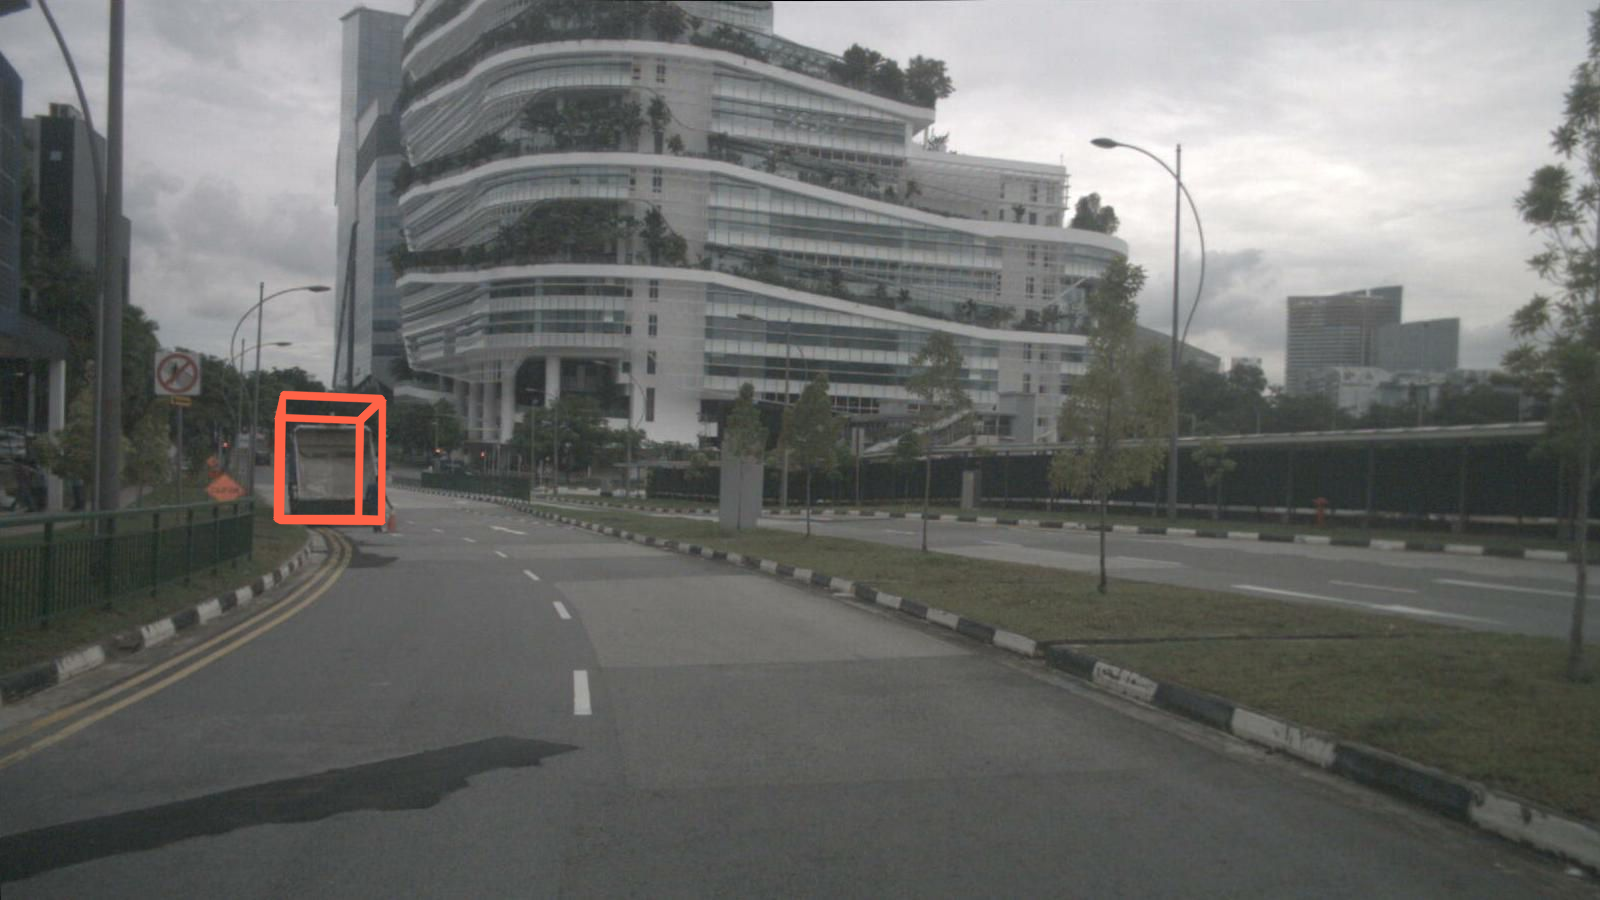

[0.5748052  0.28150123 0.35291722 0.3793266  0.3592009  0.2147631 ]
['car', 'pedestrian', 'pedestrian', 'bicycle', 'truck', 'truck']
LiDARInstance3DBoxes(
    tensor([[-7.0904e-01, -2.3994e+01, -2.1133e+00,  1.8338e+00,  4.3618e+00,
          1.5580e+00,  3.1131e+00,  7.2213e-02,  3.9794e+00],
        [-1.3314e+01, -1.5631e-01, -1.4629e+00,  5.8745e-01,  5.9789e-01,
          1.4267e+00, -7.1584e-01, -1.1262e-04, -1.4301e-04],
        [-1.3241e+01, -1.1590e+00, -1.4599e+00,  5.7226e-01,  6.0149e-01,
          1.4360e+00,  3.0434e+00,  4.6313e-04,  5.1781e-04],
        [-3.6739e+00, -9.1511e+00, -1.6470e+00,  5.2874e-01,  1.5890e+00,
          1.0457e+00, -3.1119e+00,  2.1124e-05,  9.2479e-04],
        [-1.6559e+01,  4.3064e+01, -6.2493e-01,  2.8850e+00,  9.5654e+00,
          3.7215e+00,  2.7281e+00,  1.5807e-06, -2.3969e-06],
        [-1.7042e+01,  4.4222e+01, -5.3706e-01,  2.8646e+00,  1.0221e+01,
          3.7996e+00, -4.1485e-01,  1.5807e-06, -2.3969e-06]]))


/root/bevfusion/mmdet3d/core/bbox/coders/transfusion_bbox_coder.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.post_center_range = torch.tensor(


0.24233317375183105


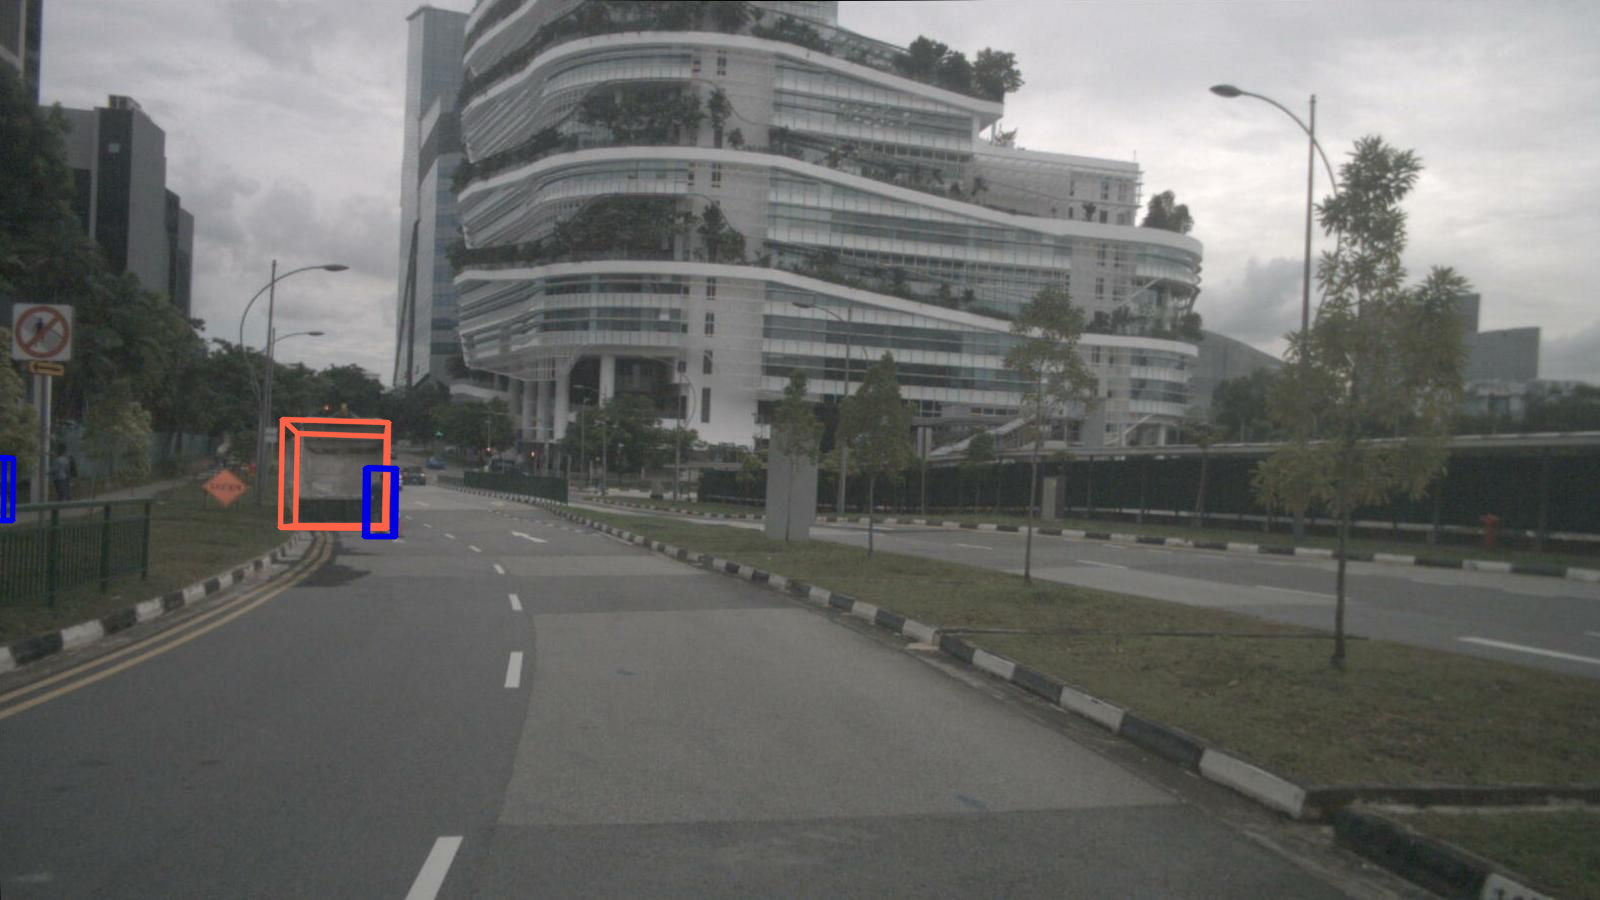

[0.6494168  0.48920858 0.4258627  0.26106092 0.24767736 0.21853541
 0.21585146 0.13809595 0.18637764 0.1744355  0.10571874]
['car', 'bicycle', 'bicycle', 'pedestrian', 'pedestrian', 'traffic_cone', 'pedestrian', 'pedestrian', 'pedestrian', 'truck', 'traffic_cone']
LiDARInstance3DBoxes(
    tensor([[-1.9303e+00, -2.5603e+01, -2.1267e+00,  1.8497e+00,  4.3743e+00,
          1.5256e+00, -3.1015e+00,  3.8757e-01,  6.6937e+00],
        [-1.3352e+01, -4.8943e+00, -1.2079e+00,  5.7336e-01,  1.6026e+00,
          1.0779e+00, -9.9116e-02, -1.7784e-04, -1.7557e-03],
        [-4.2111e+00, -1.3514e+01, -1.7079e+00,  5.6005e-01,  1.6097e+00,
          1.0807e+00, -3.1410e+00, -5.7966e-06,  7.5486e-04],
        [-2.2016e+01,  3.4423e+01, -6.3407e-01,  5.8547e-01,  5.9130e-01,
          1.6839e+00,  1.3558e+00, -6.5110e-01, -2.5508e-01],
        [-2.1951e+01,  3.3650e+01, -6.3663e-01,  5.9376e-01,  5.8685e-01,
          1.6830e+00,  1.4254e+00, -6.8942e-01, -2.7855e-01],
        [-1.0706e+01,  3.1363

In [11]:
import time
counter = 0
for i, data in enumerate(datalist):
    if i >= 2:
        break

    metas = data["metas"].data[0][0]
    name = "{}-{}".format(metas["timestamp"], metas["token"])

    with torch.inference_mode():
        start = time.time()
        outputs = model(**data) # Made predictions
        print(time.time() - start)

    gt_bboxes = data["gt_bboxes_3d"].data[0][0].tensor.numpy()
    gt_labels = data["gt_labels_3d"].data[0][0].numpy()

    gt_bboxes[..., 2] -= gt_bboxes[..., 5] / 2
    gt_bboxes = LiDARInstance3DBoxes(gt_bboxes, box_dim=9)

    # elif args.mode == "pred" and "boxes_3d" in outputs[0]:
    bboxes = outputs[0]["boxes_3d"].tensor.numpy()
    scores = outputs[0]["scores_3d"].numpy()
    labels = outputs[0]["labels_3d"].numpy()

    # Remove boxes from threshold you don't care about
    BBOX_SCORE = 0.1
    indices = scores >= BBOX_SCORE
    bboxes = bboxes[indices]
    scores = scores[indices]
    labels = labels[indices]
    
    
    bboxes[..., 2] -= bboxes[..., 5] / 2 # I don't know why they do this
    bboxes = LiDARInstance3DBoxes(bboxes, box_dim=9)
    
    # For BEV Models
    if args.mode == "gt" and "gt_masks_bev" in data:
        masks = data["gt_masks_bev"].data[0].numpy()
        masks = masks.astype(np.bool)
    elif args.mode == "pred" and "masks_bev" in outputs[0]:
        masks = outputs[0]["masks_bev"].numpy()
        masks = masks >= args.map_score
    else:
        masks = None
    
    if "img" in data:
        for k, image_path in enumerate(metas["filename"]):
            image = mmcv.imread(image_path)
            visualize_camera( # This does some extra preprocessing for some reason, 
                os.path.join(args.out_dir, f"camera-{k}", f"{labels}-{name}.png"),
                image,
                bboxes=bboxes,
                labels=labels,
                transform=metas["lidar2image"][k],
                classes=cfg.object_classes,
            )
        
        final_image = Image.open(os.path.join(args.out_dir, f"camera-0", f"{labels}-{name}.png"))
        final_image.show()
        print(scores)
        print([cfg.object_classes[label] for label in labels])
        print(bboxes)
        # plt.imshow(final_image)
        # plt.axis('off')
    
    # if "points" in data:
    #     lidar = data["points"].data[0][0].numpy()
    #     visualize_lidar(
    #         os.path.join(args.out_dir, "lidar", f"{name}.png"),
    #         lidar,
    #         bboxes=bboxes,
    #         labels=labels,
    #         xlim=[cfg.point_cloud_range[d] for d in [0, 3]],
    #         ylim=[cfg.point_cloud_range[d] for d in [1, 4]],
    #         classes=cfg.object_classes,
    #     )

    # if masks is not None:
    #     visualize_map(
    #         os.path.join(args.out_dir, "map", f"{name}.png"),
    #         masks,
    #         classes=cfg.map_classes,
    #     )

